# Comparativa de clasificadores para metroscubiertos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


# Leemos el dataset

In [2]:
df = pd.read_csv('../data/train.csv').dropna(
    subset=['precio','metroscubiertos']
)

## Agregando feature cheto

In [3]:
df['cheto'] = (
    (df['gimnasio']==1) &
    (df['piscina']==1) &
    (df['usosmultiples']==1) & 
    (df['garages']!=0)
)

df['chetocidad'] = (
    df['gimnasio'] +
    df['piscina'] +
    df['usosmultiples'] +
    df['garages']
)


Text(0.5, 1.0, 'Distribucion de metroscubiertos por grado de chetocidad')

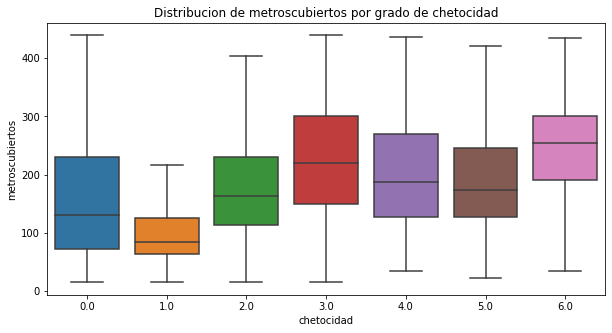

In [4]:
plt.subplots(1, 1, figsize=(10, 5))
ax = sns.boxplot(data=df, x='chetocidad', y='metroscubiertos', showfliers=False)
ax.set_title("Distribucion de metroscubiertos por grado de chetocidad")

## Corriendo los clasificadores

In [5]:
import metnum
import wrappers
import pandas as pd
import stepwise_selectors as ss

from cross_validation import cross_validate
from tqdm import tqdm

clfs = [
    ## --
    ## Predecir metros cubiertos
    # antiguedad
    {
        "segment": "antiguedad", "explains": "metroscubiertos", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
            func_segment = lambda df: wrappers.segment_by_col(df, 'antiguedad'),
        ),
    },
    {
        "segment": "antiguedad", "explains": "metroscubiertos", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='antiguedad',
        ),
    },
    {
        "segment": "antiguedad", "explains": "metroscubiertos", "kind":"quadratic",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='antiguedad',
        ),
    },

    # tipodepropiedad
    {
        "segment": "tipodepropiedad", "explains": "metroscubiertos", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
            func_segment = lambda df: wrappers.segment_by_col(df, 'tipodepropiedad'),
        ),
    },
    {
        "segment": "tipodepropiedad", "explains": "metroscubiertos", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='tipodepropiedad',
        ),
    },
    {
        "segment": "tipodepropiedad", "explains": "metroscubiertos", "kind":"quadratic",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='tipodepropiedad',
        ),
    },
    
    # sin segmentar
    {
        "segment": "None", "explains": "metroscubiertos", "kind":"linear",
        "clf": wrappers.PolynomialRegressor(
            degree=1,
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
        ),
    },
    {
        "segment": "None", "explains": "metroscubiertos", "kind":"quadratic",
        "clf": wrappers.PolynomialRegressor(
            degree=2,
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
        ),
    },
    {
        "segment": "None", "explains": "metroscubiertos", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
        ),
    },

    # chetocidad
    {
        "segment": "chetocidad", "explains": "metroscubiertos", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
            features=['habitaciones', 'banos', 'precio'],
            explain='metroscubiertos',
            func_segment = lambda df: wrappers.segment_by_col(df, 'chetocidad'),
        ),
    },
    {
        "segment": "chetocidad", "explains": "metroscubiertos", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='chetocidad',
        ),
    },
    {
        "segment": "chetocidad", "explains": "metroscubiertos", "kind":"quadratic",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['habitaciones', 'banos', 'precio'],
            e='metroscubiertos',
            seg_col='chetocidad',
        ),
    },
]

K = 4
DEBUG = False
SCORINGS = ["r2", "rmse", "rmsle"]

rows = []
dfs = []
for entry in tqdm(clfs, "classifiers"):
    clf = entry["clf"]
    kind = entry["kind"]
    explains = entry["explains"]
    segment = entry["segment"]
    name = f"{kind}-for_{explains}_by_{segment}"

    scores, pred = cross_validate(clf, clf.dropna(df), SCORINGS, K, DEBUG)
    # scores es un dict con las keys de SCORINGS, que son las
    # mismas que las columnas del dataframe.
    rows.append({
        **{
            "kind": kind,
            "explains": explains,
            "segment_by": segment,
            "name": name,
        }, 
        **scores
    })

    pred['kind'] = kind
    pred['segment'] = segment
    dfs.append(pred)

print("Creating DataFrame...")
df_results = pd.DataFrame(rows, columns=["name", "kind", "explains", "segment_by", "r2", "rmse", "rmsle"])
df_pred = pd.concat(dfs)
print("Done!")

classifiers: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Creating DataFrame...
Done!


## Analizando los resultados

### Guardando los resultados por separado

In [6]:
df_metros = df_results[df_results["explains"]=="metroscubiertos"]
df_metros.to_csv("results-metroscubiertos.csv")
df_metros.sort_values("r2", ascending=False)

,name,kind,explains,segment_by,r2,rmse,rmsle
3,projection-for_metroscubiertos_by_tipodepropiedad,projection,metroscubiertos,tipodepropiedad,0.697961,51.907610,0.291373
4,linear-for_metroscubiertos_by_tipodepropiedad,linear,metroscubiertos,tipodepropiedad,0.694908,52.167949,0.296661
5,quadratic-for_metroscubiertos_by_tipodepropiedad,quadratic,metroscubiertos,tipodepropiedad,0.694908,52.167949,0.296661
6,linear-for_metroscubiertos_by_None,linear,metroscubiertos,None,0.628759,57.575073,0.331350
1,linear-for_metroscubiertos_by_antiguedad,linear,metroscubiertos,antiguedad,0.628387,57.688087,0.335281
2,quadratic-for_metroscubiertos_by_antiguedad,quadratic,metroscubiertos,antiguedad,0.628387,57.688087,0.335281
0,projection-for_metroscubiertos_by_antiguedad,projection,metroscubiertos,antiguedad,0.617387,58.536399,0.347572
8,projection-for_metroscubiertos_by_None,projection,metroscubiertos,None,0.616611,58.509416,0.349225
10,linear-for_metroscubiertos_by_chetocidad,linear,metroscubiertos,chetocidad,0.598072,56.388977,0.336854
11,quadratic-for_metroscubiertos_by_chetocidad,quadratic,metroscubiertos,chetocidad,0.598072,56.388977,0.336854


### Analisis del error absoluto

In [7]:
import numpy as np
df_pred["error"] = np.abs(df_pred["metroscubiertos"] - df_pred["prediction"])

sns.set_style("whitegrid")

#### General

Text(0.5, 1.0, 'Distribucion de errores para prediccion de metroscubiertos por tipo de clasificador')

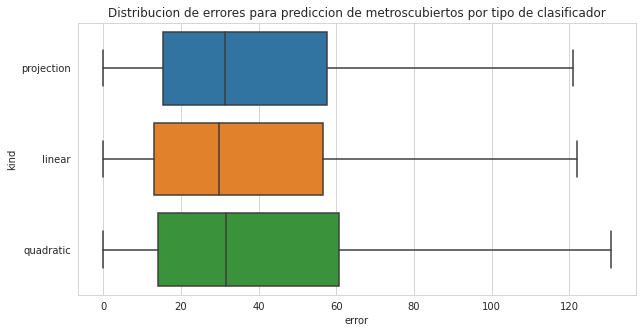

In [8]:
plt.subplots(1, 1, figsize=(10, 5))
ax = sns.boxplot(data=df_pred, x="error", y="kind", showfliers=False)
ax.set_title("Distribucion de errores para prediccion de metroscubiertos por tipo de clasificador")

#### Por tipo de segmento

Text(0.5, 1.0, 'Distribucion de errores para prediccion de precios por tipo de clasificador y segmentacion')

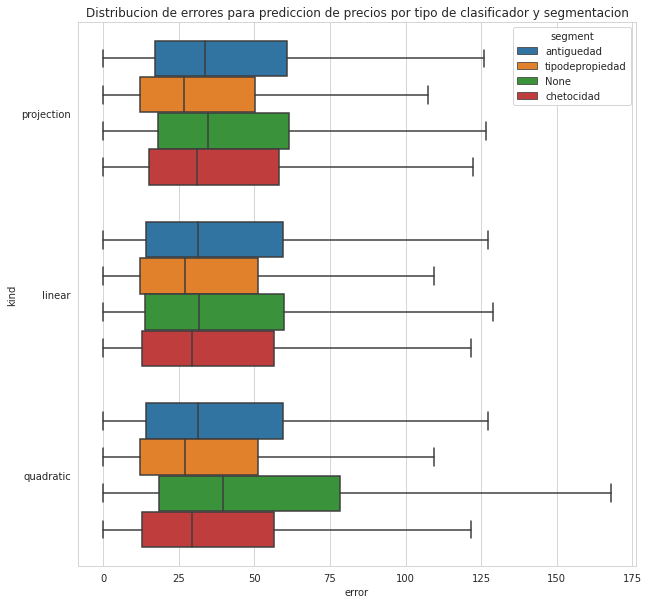

In [9]:
plt.subplots(1, 1, figsize=(10, 10))
ax = sns.boxplot(data=df_pred, x="error", y="kind", hue="segment", showfliers=False)
ax.set_title("Distribucion de errores para prediccion de precios por tipo de clasificador y segmentacion")

### Justificando elecciones de segmentacion

#### Antiguedad

Text(0.5, 1.0, 'Distribucion de metroscubiertos por antiguedad')

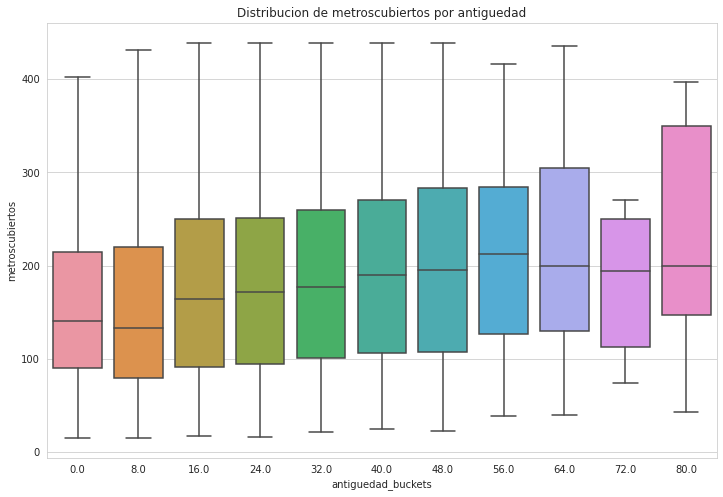

In [10]:
plt.subplots(1, 1, figsize=(12, 8))
df_pred["antiguedad_buckets"] = (df_pred["antiguedad"] // 8) * 8
ax = sns.boxplot(data=df_pred, x="antiguedad_buckets", y="metroscubiertos", showfliers=False)
ax.set_title("Distribucion de metroscubiertos por antiguedad")

#### Tipo de propiedad

Text(0.5, 1.0, 'Distribucion de metroscubiertos por tipo de propiedad')

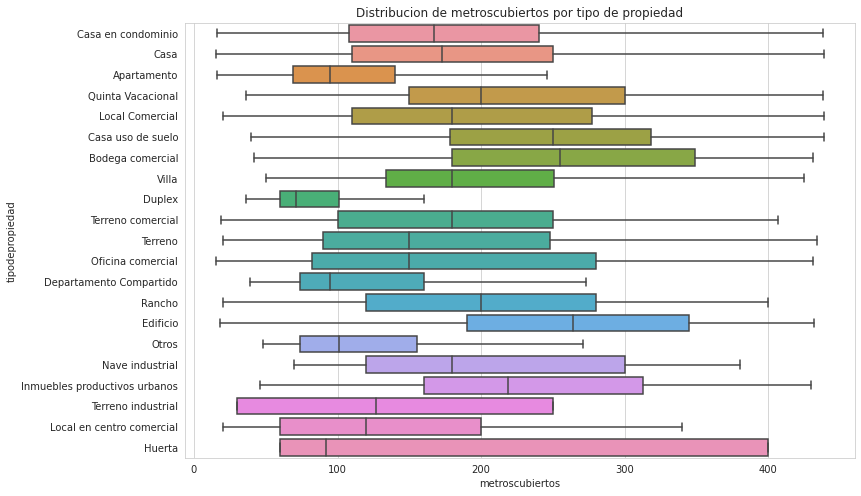

In [11]:
plt.subplots(1, 1, figsize=(12, 8))
ax = sns.boxplot(data=df_pred, x='metroscubiertos', y="tipodepropiedad", showfliers=False)
ax.set_title("Distribucion de metroscubiertos por tipo de propiedad")